<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/cifar10_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cifar10 Convnets


##Import

In [82]:
import tensorflow as tf
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import regularizers, optimizers, models, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix

##Dataset

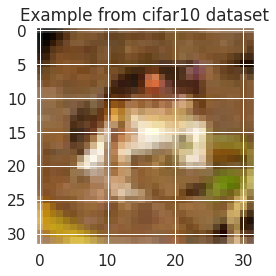

In [84]:
# DATASET - 50,000 32x32 color training images, 10,000 test images
# Labeled over 10 categories

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Show img example
img = x_train[0]
plt.imshow(img)
plt.title("Example from cifar10 dataset")

# Processing data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

batch_size = 64

# Data augmentation to generates img variation
data_gen = ImageDataGenerator(
            shear_range=0.2,
            zoom_range=0.2,
            validation_split=0.2,
            horizontal_flip=True,
            width_shift_range=0.1)

val_data_gen = ImageDataGenerator(validation_split=0.2)

# Train and validation data generators
train_data_gen = data_gen.flow(x_train, y_train, 
                               batch_size=batch_size, 
                               subset="training", seed=111)

validation_data_gen = val_data_gen.flow(x_train, y_train, 
                               batch_size=batch_size,
                               subset="validation", seed=111,
                               shuffle=False)


##Model

In [25]:
# MODEL DEFINITION 2 for GPU - model should predict the class of a given img

model = keras.Sequential()

# Convnets1
model.add(layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=x_train.shape[1:]))
model.add(layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.Dropout(0.2))

# Convnets2
model.add(layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=2, strides=2))
model.add(layers.Dropout(0.4))

# Flatten
model.add(layers.Flatten())

# Dense1
model.add(layers.Dense(units=256, activation="relu", kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001))
)
# Dense2
model.add(layers.Dense(units=256, activation="relu", kernel_regularizer=regularizers.L1L2(l1=0.0001, l2=0.0001)))
model.add(layers.Dropout(0.4))

# Output
model.add(layers.Dense(units=10, activation="softmax"))

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=["acc"],
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

##Training

In [37]:
# CALLBACK - Control iterations and save the best model possible

# Stop iterations regarding to accuracy value
early_stop = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=30)

# Saving model at each epoch if values are better than the previous ones
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

In [42]:

epochs = 100
history = model.fit(
    train_data_gen, 
    validation_data=validation_data_gen, 
    epochs=epochs, 
    batch_size=batch_size,
    callbacks=[early_stop, model_checkpoint])
#history = model.fit(x_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size)

Epoch 1/100
625/625 [==============================] - ETA: 0s - loss: 0.6264 - acc: 0.8335
Epoch 1: val_acc did not improve from 0.85920
625/625 [==============================] - 25s 40ms/step - loss: 0.6264 - acc: 0.8335 - val_loss: 0.5872 - val_acc: 0.8524
Epoch 2/100
625/625 [==============================] - ETA: 0s - loss: 0.6256 - acc: 0.8321
Epoch 2: val_acc did not improve from 0.85920
625/625 [==============================] - 24s 38ms/step - loss: 0.6256 - acc: 0.8321 - val_loss: 0.5881 - val_acc: 0.8490
Epoch 3/100
625/625 [==============================] - ETA: 0s - loss: 0.6239 - acc: 0.8339
Epoch 3: val_acc did not improve from 0.85920
625/625 [==============================] - 24s 39ms/step - loss: 0.6239 - acc: 0.8339 - val_loss: 0.5860 - val_acc: 0.8507
Epoch 4/100
624/625 [============================>.] - ETA: 0s - loss: 0.6263 - acc: 0.8318
Epoch 4: val_acc did not improve from 0.85920
625/625 [==============================] - 25s 39ms/step - loss: 0.6262 - acc: 

##Results

313/313 [==============================] - 1s 2ms/step


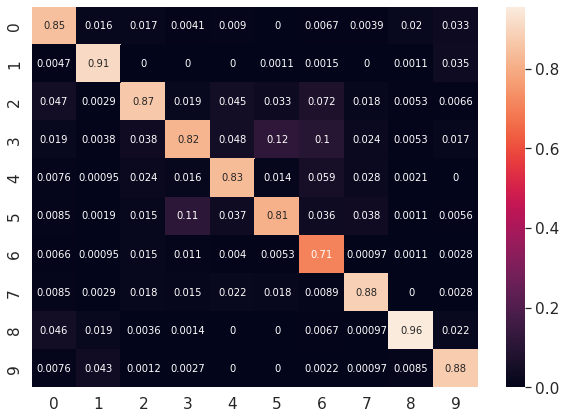

In [85]:
# CONFUSION MATRIX

#Predict
y_prediction = model.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)

y_test=np.argmax(y_test, axis=1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

df_cm = pd.DataFrame(result, range(10), range(10))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size

plt.show()


In [48]:
# EVALUATION

loss, acc = model.evaluate(x_test, y_test)
print("Accuracy : {}%".format(acc * 100))

313/313 [==============================] - 1s 5ms/step - loss: 0.5953 - acc: 0.8467
Accuracy : 84.67000126838684%
